In [1]:
# In this notebook we are comparing embeddings of a single term of interest 
# across different contexts (samples). We can compare how the pre-trained
# (toi-pt in the graph) embedding compares to our samples. With a carefully
# constructed set of samples, some sense of the semantic space of the samples
# can be inferred. 
# 
#
# This notebook supports the publication of James E. Dobson, "On Reading and 
# Interpreting Black Box Deep Neural Networks," International Journal
# of Digital Humanities (2023). https://doi.org/10.1007/s42803-023-00075-w
#
# James E. Dobson
# Dartmouth College
# https://jeddobson.github.io/


import torch
import numpy as np

from transformers import AutoModelForCausalLM, AutoTokenizer

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from operator import itemgetter

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load GPT2 XL model
model = AutoModelForCausalLM.from_pretrained('gpt2', 
                                  low_cpu_mem_usage=True,
                                  output_hidden_states=True)
tok = AutoTokenizer.from_pretrained("gpt2")

# end of sentence/text token padding
tok.pad_token = tok.eos_token

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [3]:
def describe_model():
    config = model.config.__dict__
    print("Model type: {0} ({1})".format(config['model_type'],
                                         ' '.join(config['architectures'])))
    print("Vocab size: {0}".format(config['vocab_size']))
    print("Layers: {0}".format(config['n_layer']))
    print("Embedding width: {0}".format(config['n_embd']))
    print("Parameters:\n Output Attentions: {0}\n Output Hidden States: {1}"
          .format(config['output_attentions'],
                 config['output_hidden_states']))
describe_model()

Model type: gpt2 (GPT2LMHeadModel)
Vocab size: 50257
Layers: 12
Embedding width: 768
Parameters:
 Output Attentions: False
 Output Hidden States: True


In [4]:
# Extract sentences from Theodore Dreiser's Sister Carrie (1900) using NLTK.
from nltk.tokenize import sent_tokenize, word_tokenize
text = open('EN_1900_Dreiser,Theodore_SisterCarrie_Novel.txt').read()
sentences = sent_tokenize(text)

In [5]:
# create list of tokens
tokens = word_tokenize(text)
tokens = [t.lower() for t in tokens]

In [6]:
# define a term of interest
toi = "desire"

In [7]:
# what is the frequency count for our term?
tokens.count(toi)

51

In [8]:
# return tokens and embeddings for sentence as mean token values 
# across last four layers of the model.

def get_sentence_embeddings(sentence):
    inp_tok = tok(sentence,
             padding=True,
             return_tensors="pt").to(next(model.parameters()).device)
    input_ids = inp_tok["input_ids"]
    output = model(input_ids)
    
    embs = torch.stack(output['hidden_states'], dim=0)
    embs = torch.squeeze(embs, dim=1)
    embs = embs.permute(1,0,2)
    
    vectors = [torch.sum(t[-4:], dim=0).detach().numpy() for t in embs]
    return input_ids, vectors

In [9]:
# obtain initial embedding from embedding matrix
# this is contextual, but from pre-training so we are treating
# as a static embedding (i.e., not from our contextual samples) for
# comparison with our samples.

dists = list()
token_embedding_matrix = model.lm_head.weight
inp_tok = tok(toi,
             padding=True,
             return_tensors="pt").to(next(model.parameters()).device)

initial_emb = token_embedding_matrix[inp_tok["input_ids"]]

# sum returned embeddings
initial_emb = torch.sum(initial_emb,dim=0).detach().numpy()[0]
dists.append(initial_emb)

In [10]:
dists = list()
sentence_idx = []
for sidx, sentence in enumerate(sentences):
    # why is the tokenizer behavior not consistent?
    if toi in sentence.split():
        t,v = get_sentence_embeddings(sentence)
        t = [tok.decode(id).strip() for id in t[0]]
        if toi in t:
            idx = t.index(toi)
            dists.append(v[idx])
            sentence_idx.append(sidx)

In [11]:
# create distance matrix of embeddings of just these different 
# contexts for our term of interest.
dist_matrix = 1 - cosine_similarity(dists)
for x, y in sorted(zip(np.round(dist_matrix[33],4),sentence_idx), key=itemgetter(0)):
    print(x,sentences[y])

-0.0 Her need of clothes—to say nothing of her desire for ornaments—grew rapidly as the fact developed that for all her work she was not to have them.
0.1072 She still took a faint pride in him, which was augmented by her desire to have her social integrity maintained.
0.126 Drouet, for one, was lured as much by his longing for pleasure as by his desire to shine among his betters.
0.1603 She would wait and brood, studying the details and adding to them until her power might be commensurate with her desire for revenge.
0.1654 A strong physical nature, actuated by a keen desire for the feminine, was the next.
0.1758 He was drawn by his innate desire to act the old pursuing part.
0.1768 Its principal element was daring, backed, of course, by an intense desire and admiration for the sex.
0.1876 Carrie did not exactly fancy the suggestion, but the novelty of the situation, the presence of strangers, all more or less nervous, and the desire to do anything rather than make a failure, made her

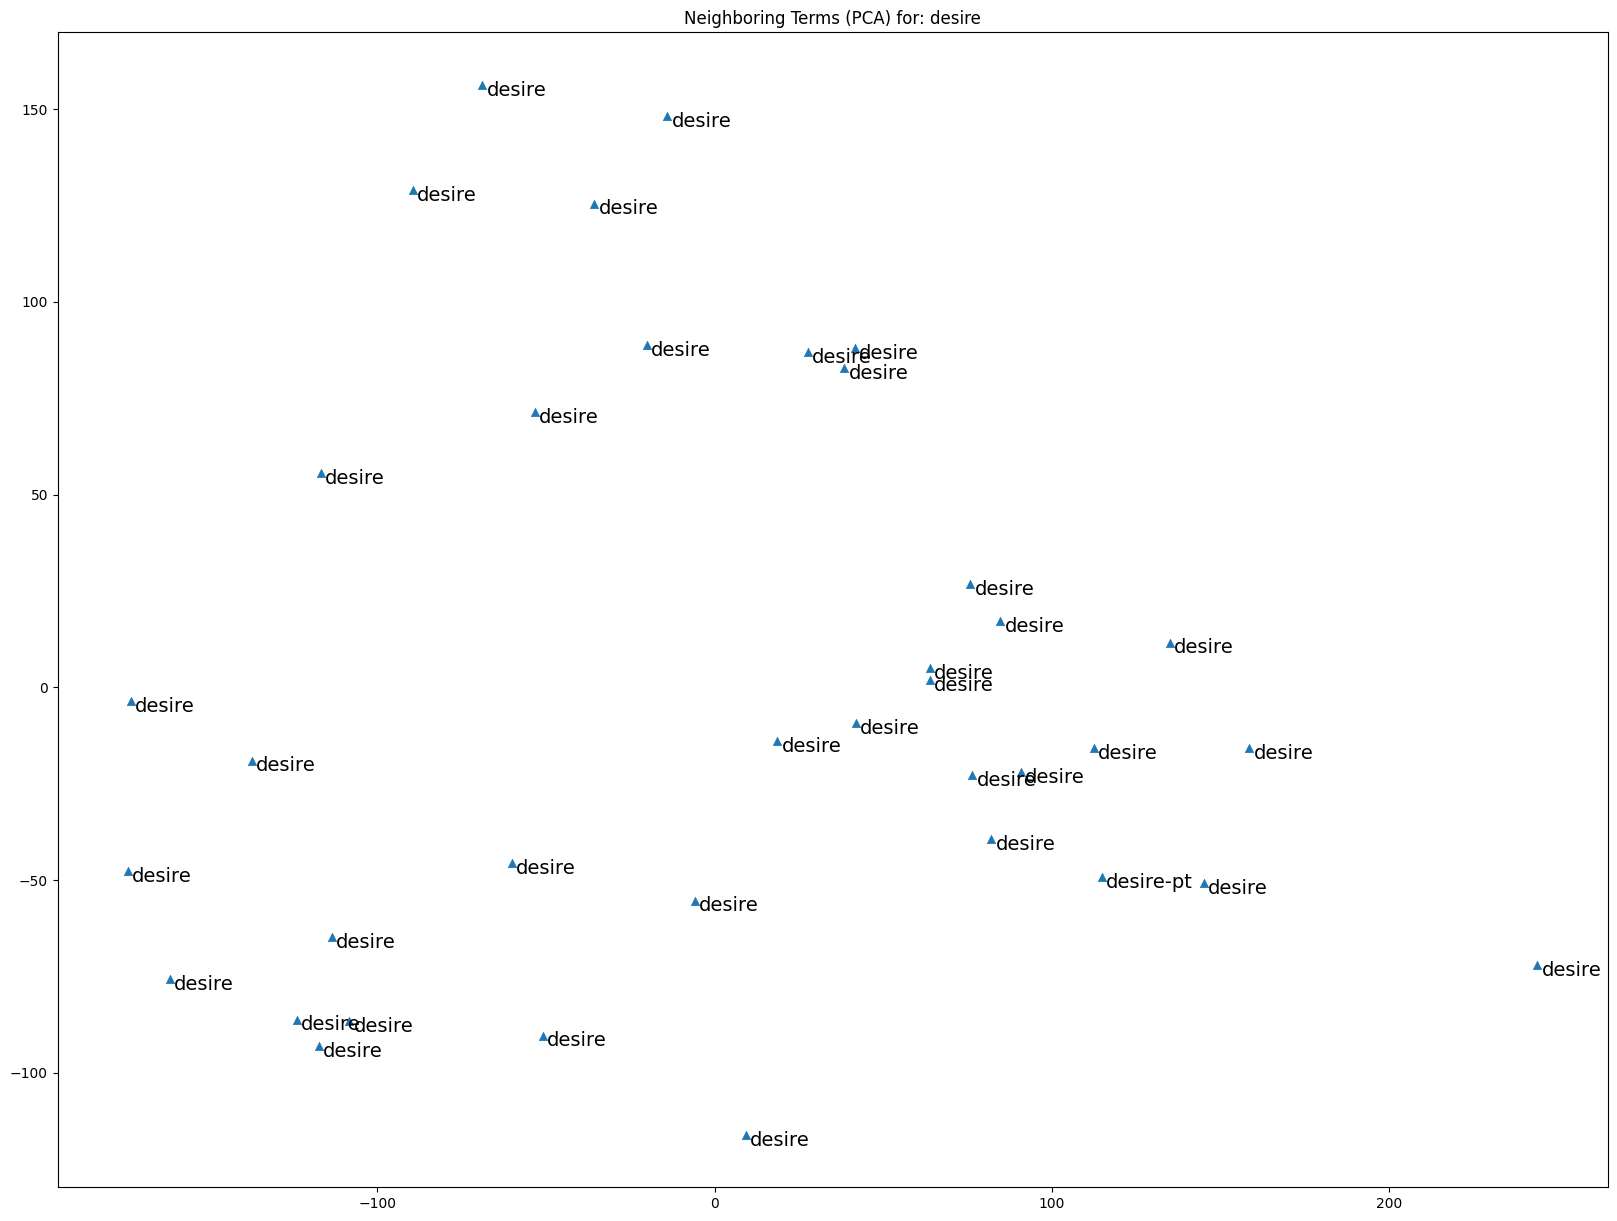

In [12]:
# reduce to 2 dimensions for plotting (just our term of interest)
pca = PCA(n_components = 2)
plot_data = pca.fit_transform(dists)

# extract x&y values
xs, ys = plot_data[:, 0], plot_data[:, 1]

# create labels
labels = [toi + "-pt"] 
labels.extend([toi] * (len(dists)-1))

# plot data
fig = plt.figure(figsize=(20, 15))
plt.clf()
plt.title("Neighboring Terms (PCA) for: " + toi)
plt.style.use('ggplot')
plt.scatter(xs, ys, marker = '^')
for i, w in enumerate(labels):
     plt.annotate(w, xy = (xs[i], ys[i]), xytext = (3, 3),fontsize=14,
                  textcoords = 'offset points', 
                  ha = 'left', 
                  va = 'top')
plt.show()  